# Neural Approaches for Recommendation system

Recommendataion Engines are one of the most popular applications of Machine learning systems. Due to their widespread success, they are quickly becoming ubiquitous to a lot of business units. 

Types of Recommendation Systems:
- Popularity based
- Content based
- Collaborative filtering
	- Nearest Neighbor
	- Matrix Factorization

Above methods are quite common to build recommendation systems. 

In the past couple of years this trend has been changing. Due to the massive success of effectively training deep neural networks, new approaches have been developed by levaraging the tools and modeling flexibility from the Deep Learning ecosystem. 

This notebook gives a quickstart concepts using neural network architectures. 

## Building book Recommendation
Goal : <font color=blue>predict the rating or preference a user would give to a book given his old books ratings or preferences. </font>

### Dataset : [goodbooks-10k](http://fastml.com/goodbooks-10k-a-new-dataset-for-book-recommendations/)

## Import Libraries

In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import warnings

# Keras
from keras.layers import Input, Embedding, Flatten, Dot, Dense, Concatenate, Dropout, multiply, concatenate
from keras.models import Model
from keras.models import load_model
from keras.utils.vis_utils import model_to_dot


from sklearn.model_selection import train_test_split
from IPython.display import SVG

warnings.filterwarnings('ignore')
%matplotlib inline


## Loading data

In [21]:
ratings_df = pd.read_csv('../data/books_dataset/ratings.csv')


## EDA

In [27]:
ratings_df.head()

,book_id,user_id,rating
0,1,314,5
1,1,439,3
2,1,588,5
3,1,1169,4
4,1,1185,4


In [28]:
ratings_df.shape

(981756, 3)

In [29]:
ratings_df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
book_id,981756.0,4943.275636,2873.207415,1.0,2457.0,4921.0,7414.0,10000.0
user_id,981756.0,25616.759933,15228.338826,1.0,12372.0,25077.0,38572.0,53424.0
rating,981756.0,3.856534,0.983941,1.0,3.0,4.0,5.0,5.0


In [35]:
# 5 ratings
ratings_df.rating.unique()

array([5, 3, 4, 1, 2])

In [36]:
# total user
n_users = ratings_df.user_id.nunique()
n_users

53424

In [37]:
# Total books
n_books = ratings_df.book_id.nunique()
n_books

10000

## Create train & test set

In [33]:
train, test = train_test_split(ratings_df, test_size=0.2, random_state=42)

In [34]:
display(train.head())
display(test.head())

,book_id,user_id,rating
341848,3423,4608,2
964349,9811,36373,5
645459,6485,2957,4
74960,750,42400,3
358670,3591,36886,5


,book_id,user_id,rating
646451,6495,19643,5
614851,6175,8563,4
974393,9920,52110,3
21471,215,33864,5
272540,2728,16587,3


## Model building

### Creating dot product model
Most recommendation systems are build using a simple dot product as shown below but newer ones are now implementing a neural network instead of the simple dot product.


#### Keras functional api working
> Create layers

> Combine everything inside model

> Compile model

> fit the model

#### Keras Dot product api is like this
`Dot(name="Dot-Product", axes=1)([book_vec, user_vec])`

In [38]:
# creating book embedding path
book_input = Input(shape=[1], name="Book-Input")
book_embedding = Embedding(n_books+1, output_dim=5, name="Book-Embedding")(book_input)
book_vec = Flatten(name="Flatten-Books")(book_embedding)

# creating user embedding path
user_input = Input(shape=[1], name="User-Input")
user_embedding = Embedding(n_users+1, output_dim=5, name="User-Embedding")(user_input)
user_vec = Flatten(name="Flatten-Users")(user_embedding)

# performing dot product and creating model
prod = Dot(name="Dot-Product", axes=1)([book_vec, user_vec])
model = Model([user_input, book_input], prod)
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

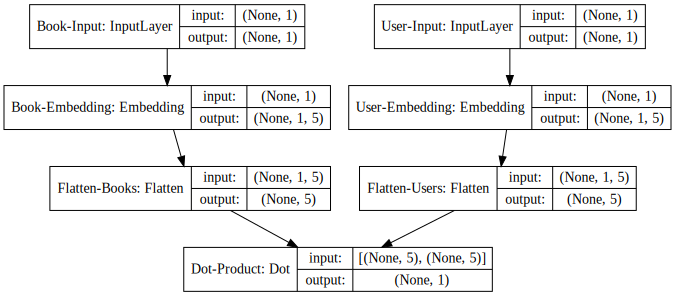

In [39]:
# Model visualization
SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))


In [40]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Book-Input (InputLayer)         (None, 1)            0                                            
__________________________________________________________________________________________________
User-Input (InputLayer)         (None, 1)            0                                            
__________________________________________________________________________________________________
Book-Embedding (Embedding)      (None, 1, 5)         50005       Book-Input[0][0]                 
__________________________________________________________________________________________________
User-Embedding (Embedding)      (None, 1, 5)         267125      User-Input[0][0]                 
__________________________________________________________________________________________________
Flatten-Bo

In [42]:
def train_and_save(model, model_name):
    epoch = 1
    if os.path.exists(f'../models/{model_name}'):
        model = load_model(f'../models/{model_name}')
    else:
        history = model.fit([train.user_id, train.book_id], train.rating, epochs=epoch, verbose=1)
        model.save(f'../models/{model_name}')
        plt.plot(history.history['loss'])
        plt.xlabel("Epochs")
        plt.ylabel("Training Error")
    return model

In [43]:
model = train_and_save(model, 'dot_product.h5')

In [44]:
# Evaluate model
display(model.evaluate([test.user_id, test.book_id], test.rating))


# make prediction
predictions = model.predict([test.user_id.head(10), test.book_id.head(10)])

[print(predictions[i], test.rating.iloc[i]) for i in range(0, 10)]


196352/196352 [==============================] - 2s 10us/step


[1.1797639321064701, 0.7913027472862053]

[5.0869145] 5
[3.7753916] 4
[3.1093779] 3
[4.4668474] 5
[3.260722] 3
[3.8262856] 3
[3.915781] 3
[5.1972065] 4
[4.1516743] 3
[4.0624285] 5


[None, None, None, None, None, None, None, None, None, None]

## Creating Neural Network

Neural Networks proved their effectiveness for almost every machine learning problems with enough data. Neurals Networks perform exceptionally well for recommendation systems. 

### Model 1 
Use Embedding multiplication and Fully connected Dense NN layer. So that model can learn complex non-linear relationship.

<img src="../data/books_dataset/model1.png" alt="Model 1" style="width: 500px;" />

In [45]:
# creating book embedding path
book_input = Input(shape=[1], name="Book-Input")
book_embedding = Embedding(n_books+1, output_dim=5, name="Book-Embedding")(book_input)

# creating user embedding path
user_input = Input(shape=[1], name="User-Input")
user_embedding = Embedding(n_users+1, output_dim=5, name="User-Embedding")(user_input)

# Combine features
o = multiply([book_embedding, user_embedding])
o = Dropout(0.5)(o)
o = Flatten(name="Flatten-Embeddings")(o)

# add fully-connected-layers
out = Dense(1)(o)

# Create model and compile it
model1 = Model([user_input, book_input], out)
model1.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


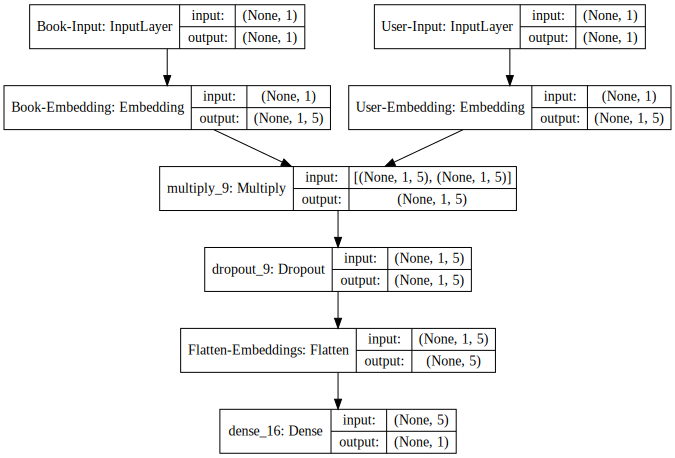

In [47]:
# Model visualization
SVG(model_to_dot(model1, show_shapes=True).create(prog='dot', format='svg'))

In [46]:
model1 = train_and_save(model1, 'model1.h5')

In [49]:
# Evaluate model
display(f'Dot_product : {[1.1797639321064701, 0.7913027472862053]}')
display(model1.evaluate([test.user_id, test.book_id], test.rating))


# make prediction
predictions = model1.predict([test.user_id.head(10), test.book_id.head(10)])

[print(predictions[i], test.rating.iloc[i]) for i in range(0, 10)]


'Dot_product : [1.1797639321064701, 0.7913027472862053]'

196352/196352 [==============================] - 2s 11us/step


[0.8265591262168259, 0.7198698723681436]

[4.515398] 5
[3.7331235] 4
[3.586336] 3
[3.8303323] 5
[3.6207504] 3
[4.328411] 3
[3.870175] 3
[4.3240137] 4
[3.972353] 3
[3.9918277] 5


[None, None, None, None, None, None, None, None, None, None]

### Model 2 
Add bias that a user might have in giving consistently high scores to every book he read or a book having consistently bad scores for all users.

<img src="../data/books_dataset/model2.png" alt="Model 2" style="width: 500px;" />

In [53]:
bias = 1

# creating book embedding path
book_input = Input(shape=[1], name="Book-Input")
book_embedding = Embedding(n_books+1, output_dim=5, name="Book-Embedding")(book_input)
book_bias = Embedding(n_books+1, bias, name="Book-Bias-Embedding")(book_input)

# creating user embedding path
user_input = Input(shape=[1], name="User-Input")
user_embedding = Embedding(n_users+1, output_dim=5, name="User-Embedding")(user_input)
user_bias = Embedding(n_users+1, bias, name="User-Bias-Embedding")(user_input)

# Combine features
o = multiply([book_embedding, user_embedding])
o = concatenate([o, book_bias, user_bias])
o = Dropout(0.5)(o)
o = Flatten(name="Flatten-Features")(o)

# add fully-connected-layers
out = Dense(1)(o)

# Create model and compile it
model2 = Model([user_input, book_input], out)
model2.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

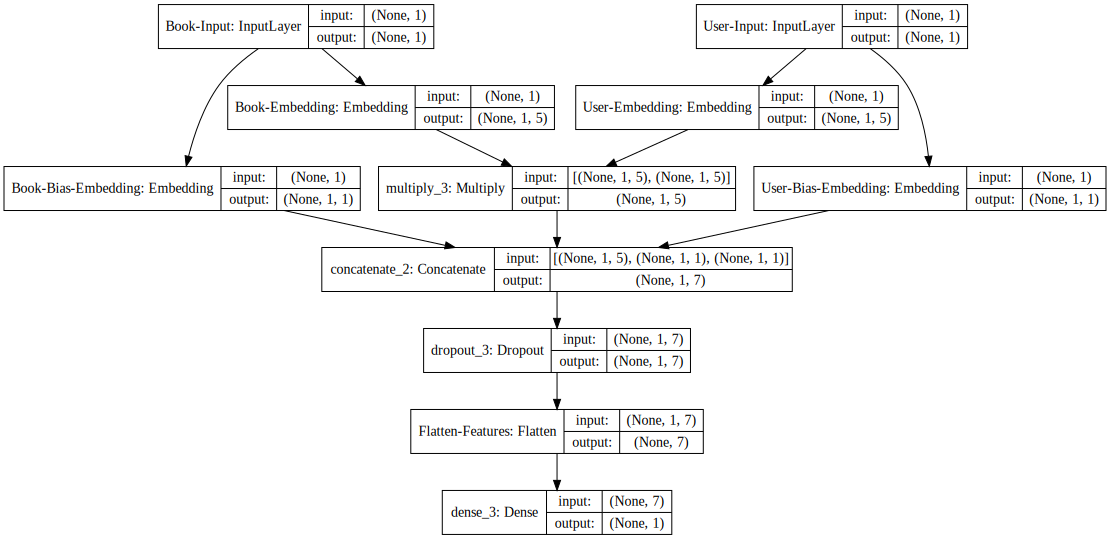

In [55]:
# Model visualization
SVG(model_to_dot(model2, show_shapes=True).create(prog='dot', format='svg'))

In [56]:
model2 = train_and_save(model2, 'model2.h5')

In [57]:
# Evaluate model
display(f'Dot_product : {[1.1797639321064701, 0.7913027472862053]}')
display(f'Model 1 : {[0.8265591262168259, 0.7198698723681436]}')

display(model2.evaluate([test.user_id, test.book_id], test.rating))


# make prediction
predictions = model2.predict([test.user_id.head(10), test.book_id.head(10)])

[print(predictions[i], test.rating.iloc[i]) for i in range(0, 10)]

'Dot_product : [1.1797639321064701, 0.7913027472862053]'

'Model 1 : [0.8265591262168259, 0.7198698723681436]'

196352/196352 [==============================] - 3s 13us/step


[0.8215828870157219, 0.7241504425097942]

[4.38785] 5
[3.8998415] 4
[3.6353] 3
[3.9487367] 5
[3.596792] 3
[3.9906795] 3
[3.718639] 3
[3.9381063] 4
[3.962413] 3
[3.9018114] 5


[None, None, None, None, None, None, None, None, None, None]

### Model 3 
Add relu activation function. It will not activate all the neurons 
<img src="../data/books_dataset/model3.png" alt="Model 3" style="width: 500px;" />

In [49]:
# creating book embedding path
bias = 1

book_input = Input(shape=[1], name="Book-Input")
book_embedding = Embedding(n_books+1, output_dim=5, name="Book-Embedding")(book_input)
# book_vec = Flatten(name="Flatten-Books")(book_embedding)
book_bias = Embedding(n_books+1, bias, name="Book-Bias-Embedding")(book_input)

# creating user embedding path
user_input = Input(shape=[1], name="User-Input")
user_embedding = Embedding(n_users+1, output_dim=5, name="User-Embedding")(user_input)
# user_vec = Flatten(name="Flatten-Users")(user_embedding)
user_bias = Embedding(n_users+1, bias, name="User-Bias-Embedding")(user_input)

# Combine features
o = multiply([book_embedding, user_embedding])
o = concatenate([o, book_bias, user_bias])
o = Dropout(0.5)(o)
o = Flatten(name="Flatten-Features")(o)

# add fully-connected-layers
out = Dense(1, activation='relu')(o)

# # concatenate features
# conc = Concatenate()([book_vec, user_vec, book_bias, user_bias])
# 
# # add fully-connected-layers
# fc1 = Dense(128)(conc)
# fc2 = Dense(32)(fc1)
# out = Dense(1)(fc2)

# Create model and compile it
model3 = Model([user_input, book_input], out)
model3.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

In [53]:
model3 = train_and_save(model3, 'model3.h5')

In [58]:
# creating book embedding path
bias = 1

book_input = Input(shape=[1], name="Book-Input")
book_embedding = Embedding(n_books+1, output_dim=5, name="Book-Embedding")(book_input)
# book_vec = Flatten(name="Flatten-Books")(book_embedding)
book_bias = Embedding(n_books+1, bias, name="Book-Bias-Embedding")(book_input)

# creating user embedding path
user_input = Input(shape=[1], name="User-Input")
user_embedding = Embedding(n_users+1, output_dim=5, name="User-Embedding")(user_input)
# user_vec = Flatten(name="Flatten-Users")(user_embedding)
user_bias = Embedding(n_users+1, bias, name="User-Bias-Embedding")(user_input)

# Combine features
o = multiply([book_embedding, user_embedding])
o = concatenate([o, book_bias, user_bias])
o = Dropout(0.2)(o)
o = Flatten(name="Flatten-Features")(o)

# add fully-connected-layers
o = Dense(128, activation='relu')(o)
o = Dropout(0.2)(o)
o = Dense(32, activation='relu')(o)
o = Dropout(0.2)(o)
out = Dense(1, activation='relu')(o)

# # concatenate features
# conc = Concatenate()([book_vec, user_vec, book_bias, user_bias])
# 
# # add fully-connected-layers
# fc1 = Dense(128)(conc)
# fc2 = Dense(32)(fc1)
# out = Dense(1)(fc2)

# Create model and compile it
model4 = Model([user_input, book_input], out)
model4.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

In [60]:
model4 = train_and_save(model4, 'model4.h5')

In [22]:

# Model 1
# creating book embedding path
book_input = Input(shape=[1], name="Book-Input")
book_embedding = Embedding(n_books+1, output_dim=5, name="Book-Embedding")(book_input)
book_vec = Flatten(name="Flatten-Books")(book_embedding)

# creating user embedding path
user_input = Input(shape=[1], name="User-Input")
user_embedding = Embedding(n_users+1, output_dim=5, name="User-Embedding")(user_input)
user_vec = Flatten(name="Flatten-Users")(user_embedding)

# concatenate features
conc = Concatenate()([book_vec, user_vec])

# add fully-connected-layers
fc1 = Dense(128)(conc)
fc2 = Dense(32)(fc1)
out = Dense(1)(fc2)

# Create model and compile it
model2 = Model([user_input, book_input], out)
model2.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

In [23]:
# Model visualization
SVG(model_to_dot(model2).create(prog='dot', format='svg'))

<IPython.core.display.SVG object>

In [24]:
model2.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Book-Input (InputLayer)         (None, 1)            0                                            
__________________________________________________________________________________________________
User-Input (InputLayer)         (None, 1)            0                                            
__________________________________________________________________________________________________
Book-Embedding (Embedding)      (None, 1, 5)         50005       Book-Input[0][0]                 
__________________________________________________________________________________________________
User-Embedding (Embedding)      (None, 1, 5)         267125      User-Input[0][0]                 
__________________________________________________________________________________________________
Flatten-Bo

Epoch 1/5
785404/785404 [==============================] - 74s 95us/step - loss: 0.7933 - mean_absolute_error: 0.6988
Epoch 2/5
785404/785404 [==============================] - 74s 94us/step - loss: 0.6930 - mean_absolute_error: 0.6464
Epoch 3/5
785404/785404 [==============================] - 71s 91us/step - loss: 0.6731 - mean_absolute_error: 0.6332
Epoch 4/5
785404/785404 [==============================] - 70s 89us/step - loss: 0.6626 - mean_absolute_error: 0.6262
Epoch 5/5
785404/785404 [==============================] - 72s 92us/step - loss: 0.6561 - mean_absolute_error: 0.6215


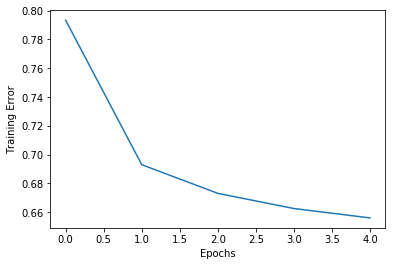

In [25]:
model2 = train_and_save(model2, 'concat_dense.h5')

In [27]:
# Evaluate model
display(model2.evaluate([test.user_id, test.book_id], test.rating))


# make prediction
predictions = model2.predict([test.user_id.head(10), test.book_id.head(10)])

[print(predictions[i], test.rating.iloc[i]) for i in range(0, 10)]


196352/196352 [==============================] - 4s 19us/step


[0.7101092591876895, 0.6583133873856363]

[4.791809] 5
[3.7440045] 4
[3.2593846] 3
[4.0801153] 5
[3.3553224] 3
[4.0821266] 3
[3.5343602] 3
[4.677662] 4
[4.016205] 3
[4.1139946] 5


[None, None, None, None, None, None, None, None, None, None]

### Model 2

The first model does not explicitly take into account the bias that a user might have in giving consistently high scores to every book he read or a book having consistently bad scores for all users. This is why we introduce a bias for each of the users and for each book. 


In [31]:
# creating book embedding path
bias = 1

book_input = Input(shape=[1], name="Book-Input")
book_embedding = Embedding(n_books+1, output_dim=5, name="Book-Embedding")(book_input)
# book_vec = Flatten(name="Flatten-Books")(book_embedding)
# book_bias = Embedding(n_books+1, bias, name="Book-Bias-Embedding")(book_input)

# creating user embedding path
user_input = Input(shape=[1], name="User-Input")
user_embedding = Embedding(n_users+1, output_dim=5, name="User-Embedding")(user_input)
# user_vec = Flatten(name="Flatten-Users")(user_embedding)
# user_bias = Embedding(n_users+1, bias, name="User-Bias-Embedding")(user_input)


o = multiply([book_embedding, user_embedding])
o = Dropout(0.5)(o)
o = Flatten()(o)
out = Dense(1)(o)

# # concatenate features
# conc = Concatenate()([book_vec, user_vec, book_bias, user_bias])
# 
# # add fully-connected-layers
# fc1 = Dense(128)(conc)
# fc2 = Dense(32)(fc1)
# out = Dense(1)(fc2)

# Create model and compile it
model3 = Model([user_input, book_input], out)
model3.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

In [32]:
model3.fit([train.user_id, train.book_id], train.rating, epochs=5, verbose=1)


Epoch 1/5
785404/785404 [==============================] - 63s 81us/step - loss: 1.8766
Epoch 2/5
785404/785404 [==============================] - 63s 80us/step - loss: 0.9200
Epoch 3/5
785404/785404 [==============================] - 67s 86us/step - loss: 0.8623
Epoch 4/5
785404/785404 [==============================] - 65s 83us/step - loss: 0.8249
Epoch 5/5
785404/785404 [==============================] - 62s 79us/step - loss: 0.7991


### Using extra information 
Often, along with the user-interaction data, other information such as user metadata and item metadata is also given. With the above networks, it's trivial to add this metadata to our model. Let's see how.

model = Model([user_input, book_input, age_input, book_contextual_input], out)


### Visualizing Embeddings
Embeddings are weights that are learned to represent some specific variables like books and user in our case and therefore we can not only use them to get good results on our recommendation problem but also to extract inside about our data.


In [62]:
# Extract embeddings
book_em = model4.get_layer('Book-Embedding')   # Book-Embedding is same name that we provided to Embedding layer
book_em_weights = book_em.get_weights()[0]

In [63]:
book_em_weights[:5]

array([[-0.0023316 ,  0.02973611, -0.00199168, -0.0213319 ,  0.01576461],
       [-0.0156836 ,  0.31365398,  0.02116846,  0.04621242,  0.04538253],
       [ 0.02768993,  0.04752402, -0.10168445, -0.08113363, -0.18637583],
       [-0.00055963,  0.06416944,  0.04395595, -0.10037446, -0.00707092],
       [-0.03931956, -0.19683403, -0.03131515,  0.15740824,  0.04369702]],
      dtype=float32)

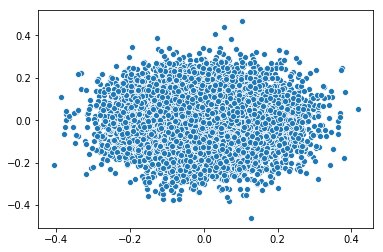

In [64]:
from sklearn.decomposition import PCA
import seaborn as sns

pca = PCA(n_components=2)   # We used output_dim=5 so 1 < n_components <=5 
pca_result = pca.fit_transform(book_em_weights)
sns.scatterplot(x=pca_result[:, 0], y=pca_result[:,1])

### Making recommendations

In [65]:
# Creating dataset for making recommendations for the first user
book_data = ratings_df.book_id.unique()
book_data[:5]

array([1, 2, 3, 4, 5])

In [66]:
np.sort(ratings_df.user_id.unique())

array([    1,     2,     3, ..., 53422, 53423, 53424])

In [67]:
user = np.array([1 for i in range(len(book_data))])
user[:5]

array([1, 1, 1, 1, 1])

In [68]:
predictions = model4.predict([user, book_data])

predictions = np.array([a[0] for a in predictions])

recommended_book_ids = (-predictions).argsort()[:5]  # sort values in decreasing order and return index

recommended_book_ids

array([7946, 7253, 8977, 8945, 2936])

In [69]:
# print predicted scores
predictions[recommended_book_ids]

array([4.564009 , 4.5529428, 4.550957 , 4.5482526, 4.536194 ],
      dtype=float32)

In [76]:
books = pd.read_csv('data/books_dataset/books.csv')
books.iloc[:, :10].head()

,id,book_id,best_book_id,work_id,books_count,isbn,isbn13,authors,original_publication_year,original_title
0,1,2767052,2767052,2792775,272,439023483,9.780439e+12,Suzanne Collins,2008.0,The Hunger Games
1,2,3,3,4640799,491,439554934,9.780440e+12,"J.K. Rowling, Mary GrandPré",1997.0,Harry Potter and the Philosopher's Stone
2,3,41865,41865,3212258,226,316015849,9.780316e+12,Stephenie Meyer,2005.0,Twilight
3,4,2657,2657,3275794,487,61120081,9.780061e+12,Harper Lee,1960.0,To Kill a Mockingbird
4,5,4671,4671,245494,1356,743273567,9.780743e+12,F. Scott Fitzgerald,1925.0,The Great Gatsby


In [77]:
books[books['id'].isin(recommended_book_ids)].iloc[:, :10]

,id,book_id,best_book_id,work_id,books_count,isbn,isbn13,authors,original_publication_year,original_title
2935,2936,64218,64218,59951,80,380821214,9.780381e+12,Terry Pratchett,1990.0,Eric
7252,7253,22875,22875,409548,34,345418476,9.780345e+12,Stephen R. Donaldson,1982.0,The One Tree
7945,7946,39926,39926,836516,43,60512180,9.780061e+12,Naomi Wolf,1990.0,The Beauty Myth: How Images of Beauty Are Used...
8944,8945,32529,32529,3214115,40,752848267,9.780753e+12,Lisa Gardner,2001.0,The Next Accident
8976,8977,8570787,8570787,13439499,25,141659907X,9.781417e+12,A.J. Jacobs,2012.0,NaN


### Summary

1. RecSys is a good use case in Data Science domain.
2. Dot product is easy to build and first step for Neural network.
3. 4 Models:
	- Model 1 : Multiply(user_vec, book_vec) + Dense NN layer
	- Model 2 : Added bias inside concatenation layer concatenate([o, book_bias, user_bias])
	- Model 3 : Added 'relu' Activation function inside Dense NN layer. 
	- Model 4 : Added more Dense layers to check if perfomance optimizes. 
4. Embedding visualization
5. Book recommendation

### Credit where it's due
 - A brilliant [fast.ai](https://course.fast.ai/videos/?lesson=4) course by Jeremy and Rachel. Refer to Lesson 4 for Collaborative Filtering lecture.
 - Deep learning class. [link](https://m2dsupsdlclass.github.io/lectures-labs/)
 - Reference: Keras Model guide. [link](http://faroit.com/keras-docs/1.0.4/getting-started/sequential-model-guide/)

### For those who'd like to get deeper
 - Deep Recommender models using PyTorch - Spotlight. The Keras implementation.
 - YouTube Recommendation Engine (Combination of techniques)
 - Google Play Apps Recommendations Engine
 - RecSys conference 2017 had a lot of talks where deep learning was the primary theme. Official reviews here.
